## Imports


In [ ]:
import torch
import torchvision

from matplotlib.pyplot import imshow

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, RandomRotation, RandomHorizontalFlip, RandomCrop, Normalize
from torchvision.transforms.functional import pil_to_tensor
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch.nn.functional as F

## Load in CIFAR-10 - and prepare DataLoader
### Transformation: RandomRotation (10 degrees)  
### Transformation: RandomCrop (original size, but padded with 4 pixels on all sides  
### Transformation: Horizontally Flipped
#### All are normalized
All loaded into a concatenated dataset and then shuffled using a DataLoader.

In [ ]:
# Download CIFAR-10 IF NOT ALREADY EXISTS
train = CIFAR10("/cifardata", download=True, transform=Compose([ToTensor(), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=True) # We transform the data to tensors
train_hflip = CIFAR10("/cifardata", transform=Compose([ToTensor(), RandomHorizontalFlip(1.0), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=True) # We transform the data to tensors and horizontally flip them
train_rotate = CIFAR10("/cifardata", transform=Compose([ToTensor(), RandomRotation(10), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=True) # We transform the data to tensors and rotate them by 10 degrees
train_crop = CIFAR10("/cifardata", transform=Compose([ToTensor(), RandomCrop(32, padding=4), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=True) # We transform the data to tensors and crop with padding (remove some edges)

train_kaggle = CIFAR10("/cifardata", transform=Compose([RandomCrop(32, padding=4, padding_mode="reflect"), RandomHorizontalFlip(), ToTensor(), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=True) # We transform the data to tensors

test = CIFAR10("/cifardata", download=True, transform=Compose([ToTensor(), Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=False) # Once downloaded.

concatDataset = torch.utils.data.ConcatDataset([train,train_hflip,train_rotate, train_crop])

def get_train_loader(batch_size:int = 32):
  return DataLoader(concatDataset, batch_size=batch_size, shuffle=True, drop_last=True)

def get_test_loader(batch_size=1):
  return DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=False)

def get_kaggle_loader(batch_size:int = 200):
  return DataLoader(train_kaggle, batch_size=batch_size, shuffle=True, drop_last=True)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /cifardata/cifar-10-python.tar.gz to /cifardata
Files already downloaded and verified


# Neural Network Models

## Dense Neural Network (DNN)

In [ ]:
class NNModel(nn.Module): ## Simple Feedforward Neural Network
  def __init__(self):
    super(NNModel, self).__init__()
    self.flattener = nn.Flatten()
    self.ln1 = nn.Linear(32*32*3, 512)
    self.ln2 = nn.Linear(512, 512)
    self.ln3 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.flattener(x) # flatten to vector, input layer
    x = F.relu(self.ln1(x)) # deep layer 1
    x = F.relu(self.ln2(x)) # deep layer 2
    x = self.ln3(x)# output layer
    return x # return logits

DNNModel = NNModel()


## Simple Convolutional Neural Network

In [ ]:
## DEFINE CONVELUTIONAL NEURAL NETWORK MODEL

class CONVModel(nn.Module):
  def __init__(self):
    super(CONVModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1))
    self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
    self.pool1 = nn.MaxPool2d(2, 2)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.flattener = nn.Flatten()
    self.ln1 = nn.Linear(8*8*64, 64)
    self.ln2 = nn.Linear(64, 10)
  
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.flattener(x)
    x = F.relu(self.ln1(x))
    x = self.ln2(x)
    return x

CONVModel = CONVModel()

## 8-Layer Self-implemented Residual Neural Network
### As per https://arxiv.org/pdf/1512.03385.pdf

In [ ]:

class ResidualBlock(nn.Module):
  def __init__(self, channel_in, channel_out, downsample: bool = False):
    super(ResidualBlock, self).__init__()
    self.identity_map = nn.Sequential()

    if downsample:
      self.identity_map = nn.Sequential(
          nn.Conv2d(channel_in, channel_out, kernel_size=(1,1), stride=2),
          nn.BatchNorm2d(channel_out))

    self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=(3,3), stride=1, padding=1)
    self.bNorm1 = nn.BatchNorm2d(channel_out)

    if downsample:
      self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=(3,3), stride=2, padding=1)

    self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=(3,3), stride=1, padding=1)
    self.bNorm2 = nn.BatchNorm2d(channel_out)


  def forward(self, x):
    res = self.conv1(x)
    res = F.relu(self.bNorm1(res))
    res = self.conv2(res)
    res = self.bNorm2(res)
    res = F.relu(res)
    return F.relu(res + self.identity_map(x))


class ResidualNetSimple(nn.Module):
  def __init__(self):
    super(ResidualNetSimple, self).__init__()

    self.conv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = (3,3), stride=2)
    self.pool = nn.MaxPool2d(kernel_size = (3,3), stride=1) # stride = 2

    self.r1 = ResidualBlock(64, 64)
    self.r2 = ResidualBlock(64, 64)
    self.r3 = ResidualBlock(64, 128, True)
    self.r4 = ResidualBlock(128, 128)
    self.r5 = ResidualBlock(128, 256, True)
    self.r6 = ResidualBlock(256, 256)
    self.r7 = ResidualBlock(256, 512, True)
    self.r8 = ResidualBlock(512, 512)
  
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.linear = nn.LazyLinear(out_features=10)

  def forward(self, x):

    res = F.relu(self.conv(x))
    res = F.relu(self.pool(res))

    res = self.r1(res)
    res = self.r2(res)
    res = self.r3(res)
    res = self.r4(res)
    res = self.r5(res)
    res = self.r6(res)
    res = self.r7(res)
    res = self.r8(res)

    res = self.avgpool(res)

    res = self.flatten(res)
    res = self.linear(res)
    return res

ResModel = ResidualNetSimple()


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## 34-Layer Self-implemented Residual Neural Network

In [ ]:
class ResidualBlock2(nn.Module):
  def __init__(self, channel_in, channel_out, downsample=None , stride=1):
    super(ResidualBlock2, self).__init__()
    self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=(3,3), stride=stride, padding=1)
    self.bNorm1 = nn.BatchNorm2d(channel_out)
    self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=(3,3), stride=1, padding=1)
    self.bNorm2 = nn.BatchNorm2d(channel_out)
    self.relu = nn.ReLU()
    self.downsample = downsample


  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bNorm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bNorm2(x)
    x = self.relu(x)

    if self.downsample is not None:
      identity = self.downsample(identity)
    # print(x.shape , identity.shape , self.conv1)
    x = x + identity
    x = self.relu(x)
    return x

class ResidualNetLarger(nn.Module): #[3,4,6,3]
  def __init__(self , ResidualBlock2 , layers , img_channels, classes):
    super(ResidualNetLarger, self).__init__()

    self.channel_in = 64
    self.conv1 = nn.Conv2d(img_channels, 64 , kernel_size=7, stride=2, padding=3)
    self.bNorm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self.layer(ResidualBlock2, 64, layers[0], channel_out=64, stride=1)
    self.layer2 = self.layer(ResidualBlock2, 64, layers[1], channel_out=128, stride=2)
    self.layer3 = self.layer(ResidualBlock2, 128, layers[2], channel_out=256, stride=2)
    self.layer4 = self.layer(ResidualBlock2, 256, layers[3], channel_out=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.LazyLinear(classes)

  def forward(self, x):
      x = self.conv1(x)
      x = self.bNorm1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = nn.Flatten()(x)
      x = self.fc(x)

      return x


  def layer(self, ResidualBlock2, channel_in, count_residual_blocks, channel_out, stride):
    downsample = None
    layers = []

    if stride != 1 or channel_in != channel_out:
      downsample = nn.Sequential(nn.Conv2d(channel_in, channel_out, kernel_size=1, stride=stride),
                                 nn.BatchNorm2d(channel_out))
      
    layers.append(ResidualBlock2(channel_in, channel_out, downsample, stride))
    channel_in = channel_out

    for i in range(count_residual_blocks-1):
      layers.append(ResidualBlock2(channel_in, channel_out))

    return nn.Sequential(*layers)

def ResNet34(img_channel=3 , classes = 10):
  return ResidualNetLarger(ResidualBlock2, [3, 4, 6, 3], img_channel, classes)

Res34Model = ResNet34()

## PyTorch ResNet Model

In [ ]:
TorchResModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from torchvision import models
model_vgg = models.vgg16(pretrained = False)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Model Tests
Simple assertions on input & output

In [ ]:
## TEST BATCH SIZE 64
test_data = torch.rand(64, 3, 32, 32)
output = DNNModel(test_data)
assert output.shape == (64, 10)

output2 = CONVModel(test_data)
assert output2.shape == (64, 10)

output3 = ResModel(test_data)
assert output3.shape == (64, 10)

output4 = Res34Model(test_data)
assert output4.shape == (64, 10)

output5 = TorchResModel(test_data)
assert output5.shape == (64, 1000)

In [ ]:
# OPTIMIZER & LOSS FUNCTION
loss_function = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(DNNModel.parameters(), lr=1e-02)
optimizer2 = torch.optim.Adam(CONVModel.parameters(), lr=1e-02)
optimizer3 = torch.optim.Adam(ResModel.parameters(), lr=1e-02)
optimizer4 = torch.optim.Adam(Res34Model.parameters(), lr=1e-02)

# Overfit to following values and target:
training_values1 = torch.rand(10, 3, 32, 32)
training_values2 = torch.rand(10, 3, 32, 32)
training_values3 = torch.rand(10, 3, 32, 32)
training_values4 = torch.rand(10, 3, 32, 32)
training_target = torch.Tensor(list(range(10))[::-1]).long()

for i in range(50):
  val1, val2, val3, val4 = DNNModel(training_values1), CONVModel(training_values2), ResModel(training_values3), Res34Model(training_values4)
  loss1, loss2, loss3, loss4 = loss_function(val1, training_target), loss_function(val2, training_target), loss_function(val3, training_target), loss_function(val4, training_target)
  optimizer1.zero_grad()
  optimizer2.zero_grad()
  optimizer3.zero_grad()
  optimizer4.zero_grad()
  loss1.backward()
  loss2.backward()
  loss3.backward()
  loss4.backward()
  optimizer1.step()
  optimizer2.step()
  optimizer3.step()
  optimizer4.step()

print(torch.argmax(DNNModel(training_values1), dim=1), training_target)
print(torch.argmax(CONVModel(training_values2), dim=1), training_target)
print(torch.argmax(ResModel(training_values3), dim=1), training_target)
print(torch.argmax(Res34Model(training_values4), dim=1), training_target)



tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0]) tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])


# Custom Definitions for data_loader and loss
 (No longer used in favor of built-in, more stable, implementations)

In [ ]:
## LOSS FUNCTION
# CROSS ENTROPY LOSS

def cross_entropy_loss(logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
  def softmax_average(values: torch.Tensor, target: int):
    return torch.exp(value[target]) / torch.sum(torch.exp(values))

  if logits.shape[0] != len(target):
    print("LOGITS SHAPE (BATCH, C) DOES NOT EQUAL TARGET SHAPE (C,)")
  else:
    loss = 0
    for index, value in enumerate(logits):
      loss += -torch.log(softmax_average(value, target[index]))
    return loss

def get_new_batch(dataset, index: int, take_out_last: bool = True):

  tmp_values  = torch.zeros((batch_size, 3, 32, 32))
  tmp_targets = torch.zeros((batch_size))
  try:
    for f, i in enumerate(range(index, index + batch_size)):
      tmp_values[f] = dataset[i][0] / 255.0
      tmp_targets[f] = dataset[i][1]
  except IndexError as E:
    if take_out_last:
      return None, None
  return tmp_values.to(device), tmp_targets.to(device)

# Main Training Loop

In [ ]:
# Define neccessary variables
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs = 5
batch_size = 256

model = model_vgg
model.to(device) 

# DATA LOADERS
train_loader = get_train_loader(batch_size)
test_loader = get_test_loader(200)

# OPTIMIZER & LOSS FUNCTION
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-07)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-03, epochs=epochs, steps_per_epoch=len(train_loader))

val_losses = []

#####################
# INITIAL TEST LOSS #
#####################

val_loss = 0
for val, targ in iter(test_loader):
  loss = loss_function(model(val.to(device)), targ.to(device))
  val_loss += loss.sum().item()
val_losses.append(val_loss)

for epoch in range(epochs):
  print(f"----- EPOCH {epoch + 1} -----")

  ##################
  # MAIN TEST LOOP #
  ##################

  running_loss = 0
  model.train()
  mean_loss_list1 = []

  for batch, (vals, real_targs) in enumerate(iter(train_loader)):
    vals, real_targs = vals.to(device), real_targs.to(device)
    model_targs = model(vals)

    # zero grad the optimizer
    optimizer.zero_grad()

    # calculate loss
    loss = loss_function(model_targs, real_targs)
    running_loss += loss.item()
    # Backpropogate loss
    loss.backward()

    # Step optimizer
    optimizer.step()
    scheduler.step()


    # append to mean_loss
    mean_loss_list1.append(running_loss/batch_size)

    if (batch + 1) % 100 == 0:
      print(f"\t\tBATCH {(batch+1)}:\tBatch Loss: {running_loss:.2f}\tMean loss: {(running_loss/batch_size):.2f}\t")
      running_loss = 0
    
  ###########################
  # END-OF-EPOCH VALIDATION #
  ###########################
  print(f"----- END OF EPOCH {epoch + 1} -----")
  print(f" *** RUNNING VALIDATION TEST ***")
  model.eval()
  val_loss = 0
  for val, targ in iter(test_loader):
    val_loss += loss_function(model(val.to(device)), targ.to(device)).item()
  val_losses.append(val_loss)
  wrong, correct = 0, 0

  for val, targ in iter(get_test_loader(batch_size=32)):
    val, targ = val.to(device), targ.to(device)

    val = model(val)
    for v, t in zip(val, targ):
      if torch.argmax(v).item() == t.item():
        correct += 1
      else:
        wrong += 1
  print(f"\tTest Accuracy: {correct/(correct+wrong)}")
print(f"DONE!")

----- EPOCH 1 -----
		BATCH 100:	Batch Loss: 14.17	Mean loss: 0.06	
		BATCH 200:	Batch Loss: 13.99	Mean loss: 0.05	
		BATCH 300:	Batch Loss: 14.73	Mean loss: 0.06	
		BATCH 400:	Batch Loss: 17.93	Mean loss: 0.07	
		BATCH 500:	Batch Loss: 23.90	Mean loss: 0.09	
		BATCH 600:	Batch Loss: 26.06	Mean loss: 0.10	
		BATCH 700:	Batch Loss: 32.37	Mean loss: 0.13	
----- END OF EPOCH 1 -----
 *** RUNNING VALIDATION TEST ***
	Test Accuracy: 0.822
----- EPOCH 2 -----
		BATCH 100:	Batch Loss: 36.06	Mean loss: 0.14	
		BATCH 200:	Batch Loss: 41.31	Mean loss: 0.16	
		BATCH 300:	Batch Loss: 40.15	Mean loss: 0.16	
		BATCH 400:	Batch Loss: 46.10	Mean loss: 0.18	
		BATCH 500:	Batch Loss: 39.26	Mean loss: 0.15	
		BATCH 600:	Batch Loss: 40.18	Mean loss: 0.16	
		BATCH 700:	Batch Loss: 39.70	Mean loss: 0.16	
----- END OF EPOCH 2 -----
 *** RUNNING VALIDATION TEST ***
	Test Accuracy: 0.8293
----- EPOCH 3 -----
		BATCH 100:	Batch Loss: 31.83	Mean loss: 0.12	
		BATCH 200:	Batch Loss: 31.44	Mean loss: 0.12	
		BATCH

# Plots & Statistics

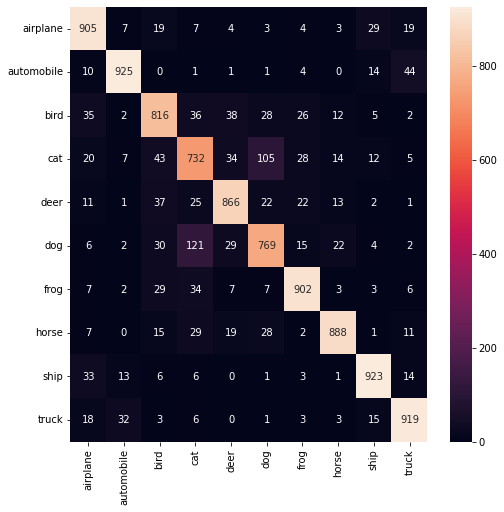

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix:
predictions = []
real = []

for v, t in iter(get_test_loader(32)):
  predictions.extend(model(v.to(device)).argmax(1).cpu())
  real.extend(t.cpu())

#The following 7 lines are all that is required to plot the confusion matrix.
predictions_for_cm = predictions

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

cm = confusion_matrix(real,predictions_for_cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  fmt=".0f", xticklabels=class_names, yticklabels = class_names)

## T-Test

In [ ]:
import scipy.stats as stats
!pip install pingouin
from pingouin import ttest
###########
# T-Test: #
###########
stats.ttest_rel(mean_loss_list1, mean_loss_list2)

ttest(mean_loss_list1, mean_loss_list2, paired = True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-48.60822,780,two-sided,3.041508e-238,"[-0.03, -0.03]",0.19968,1.246e+234,0.999849


In [ ]:
import math
###################################
# Confidence interval for models: #
###################################

# IF confidence interval of proportion is 10% > p > 90%

# name: Agresti-Coull interval

#Sample size
n = 10000

#proportion
p = 0.89

def Conf_interval():
  if p < 0.1 or p > 0.9:
    p_hat = (p*n+2)/(n+4)
    n_hat = n+4

    Agresti_Coull_upper = p_hat + 1.96 * math.sqrt((p_hat*(1-p_hat))/n_hat)
    Agresti_Coull_lower = p_hat - 1.96 * math.sqrt((p_hat*(1-p_hat))/n_hat)

    return Agresti_Coull_lower , Agresti_Coull_upper

  else:
    upper = p + 1.96 * math.sqrt(p*((1-p)/n))
    lower = p - 1.96 * math.sqrt(p*((1-p)/n))
    return lower , upper

print(Conf_interval())

(0.8838673607639125, 0.8961326392360875)


In [ ]:
wrong, correct = 0, 0

for val, targ in iter(get_test_loader(batch_size=32)):
  val, targ = val.to(device), targ.to(device)

  val = model(val)
  for v, t in zip(val, targ):
    if torch.argmax(v).item() == t.item():
      correct += 1
    else:
      wrong += 1

print(f"Total: {wrong+correct} ; Wrong: {wrong}, Correct: {correct}, average: {correct/(wrong+correct) * 100.0}%")